In [1]:
import xgboost as xgb

model_xgb = xgb.Booster()
model_xgb.load_model("xgb_no1_no_bool_lookback_24.json")

In [2]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
from msal import PublicClientApplication

from cognite.client import CogniteClient
from cognite.client.data_classes import TimeSeries, Asset

# Log-in detaljer
TENANT_ID = os.getenv("AZURE_TENANT_ID")
CLIENT_ID = os.getenv("AZURE_CLIENT_ID")
CDF_CLUSTER = "az-power-no-northeurope"
COGNITE_PROJECT = "heco-dev"

# Code to log-in WIHTOUT client_secret
SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000


def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds


creds = authenticate_azure()

client = CogniteClient(
    token_url=creds["id_token_claims"]["iss"],
    token=creds["access_token"],
    token_client_id=creds["id_token_claims"]["aud"],
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cognite-python-dev",
)

In [3]:
# Defining curves
curves = ["NO1_consumption_per_15min",
"NO1_el_price_per_hour",
"NO1_temperature_per_15min",
"NO1_cloud_coverage_per_15min",
# "NO1_consumption_forecast_per_15min"
]

# Defining relevant dates
start_date = datetime(2022,6,4)
end_date = datetime(2022,6,7)

df_watt = pd.DataFrame()
for curve in curves:
    print(curve)
    hm = client.datapoints.retrieve_dataframe(
        start=start_date,
        end=end_date,
        aggregates=["average"],
        granularity="1h",
        id=client.time_series.retrieve(external_id=curve).id,)
    df_watt = pd.merge(df_watt, hm, left_index=True, right_index=True, how="outer")

df_watt.columns = ["cons_actual","price_forecast","temp_forecast","cc_forecast"]

NO1_consumption_per_15min
NO1_el_price_per_hour
NO1_temperature_per_15min
NO1_cloud_coverage_per_15min


In [4]:
df_watt

,cons_actual,price_forecast,temp_forecast,cc_forecast
2022-06-04 00:00:00,2383.500,143.11,9.0875,0.20500
2022-06-04 01:00:00,2367.125,142.79,8.2750,0.18750
2022-06-04 02:00:00,2320.250,142.47,8.1875,0.31375
2022-06-04 03:00:00,2281.500,142.61,9.0000,0.35875
2022-06-04 04:00:00,2302.375,144.39,10.6375,0.48250
...,...,...,...,...
2022-06-06 19:00:00,2727.125,140.02,17.7000,0.89875
2022-06-06 20:00:00,2670.750,140.15,16.1375,0.96125
2022-06-06 21:00:00,2589.000,130.16,14.9125,0.97250
2022-06-06 22:00:00,2402.125,121.35,14.2000,0.99125


In [5]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())
from sklearn.model_selection import train_test_split

In [6]:
df_watt['Seconds'] = df_watt.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
week = day*7

df_watt['Day sin'] = np.sin(df_watt['Seconds'] * (2* np.pi / day))
df_watt['Day cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / day))
df_watt['Week sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Week cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Year sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / year))
df_watt['Year cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / year))

df_watt=df_watt.drop(['Seconds'], axis=1)
df_watt

,cons_actual,price_forecast,temp_forecast,cc_forecast,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
2022-06-04 00:00:00,2383.500,143.11,9.0875,0.20500,-1.513536e-12,1.000000,0.974928,-0.222521,0.466789,-0.884369
2022-06-04 01:00:00,2367.125,142.79,8.2750,0.18750,2.588190e-01,0.965926,0.965926,-0.258819,0.466154,-0.884703
2022-06-04 02:00:00,2320.250,142.47,8.1875,0.31375,5.000000e-01,0.866025,0.955573,-0.294755,0.465520,-0.885037
2022-06-04 03:00:00,2281.500,142.61,9.0000,0.35875,7.071068e-01,0.707107,0.943883,-0.330279,0.464886,-0.885371
2022-06-04 04:00:00,2302.375,144.39,10.6375,0.48250,8.660254e-01,0.500000,0.930874,-0.365341,0.464251,-0.885704
...,...,...,...,...,...,...,...,...,...,...
2022-06-06 19:00:00,2727.125,140.02,17.7000,0.89875,-9.659258e-01,0.258819,-0.916562,-0.399892,0.423795,-0.905758
2022-06-06 20:00:00,2670.750,140.15,16.1375,0.96125,-8.660254e-01,0.500000,-0.930874,-0.365341,0.423146,-0.906062
2022-06-06 21:00:00,2589.000,130.16,14.9125,0.97250,-7.071068e-01,0.707107,-0.943883,-0.330279,0.422496,-0.906365
2022-06-06 22:00:00,2402.125,121.35,14.2000,0.99125,-5.000000e-01,0.866025,-0.955573,-0.294755,0.421847,-0.906667


In [7]:
df_watt.columns = ["cons_actual", "price_forecast", "temp_forecast", "cc_forecast", "Day sin","Day cos","Week sin","Week cos","Year sin","Year cos"]

In [8]:
X_parameter = ["temp_forecast", "price_forecast", "cc_forecast", "Day sin", "Day cos","Week sin", "Week cos","Year sin","Year cos"]
X_test, Y_test = df_watt[X_parameter], df_watt["cons_actual"]
#Merk at train_test_split henter data randome, og kan ikke brukes
#Valgte her å splitte ved 2000, så trener på 2000 verdier og tester på 172
# df_watt.shape

# print(X_train)
# print(X_test)
# print(Y_train)
# print(Y_test)

In [9]:
X_test.dropna(inplace=True)
X_test = xgb.DMatrix(X_test)

C:\Users\57861\AppData\Local\Temp\ipykernel_23500\866218682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.dropna(inplace=True)


In [10]:
prediction = model_xgb.predict(X_test)
# prediction_2 = reg_2.predict(X_test_2)
# prediction_3 = reg_3.predict(X_test)
# date = df_watt.index.to_frame()
# date_train, date_test, date_3 = date[:47000], date[47000:], date[46500:47000]

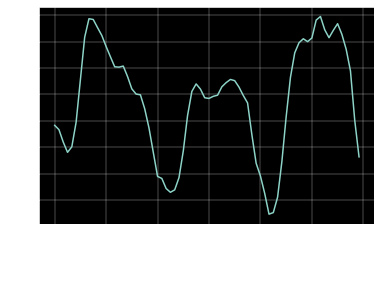

In [11]:
date = df_watt.index.to_frame()
plt.style.use('dark_background')
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
plt.plot(date,df_watt["cons_actual"])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

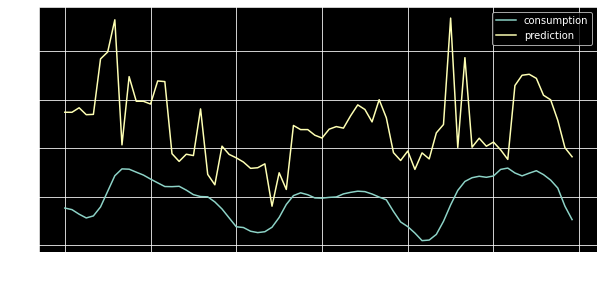

In [12]:
plt.figure(figsize=(10,5))
plt.plot(date,df_watt['cons_actual'], label = "consumption")
#plt.plot(date_test, (prediction+150), label='prediction + 150')
plt.plot(date, prediction, label='prediction')
#plt.plot(date_test, prediction_2, label = "prediction without sin and cos")
#plt.plot(date_test, prediction_3, label = "prediction learning = 0.3")
#Beautify x-axis
plt.grid()
plt.xticks(rotation=90)
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# df_watt = df_watt.dropna()

cons_actual = df_watt["cons_actual"].values
cons_forecast = prediction

# cons_actual = cons_actual[~np.isnan(cons_actual)]
# cons_forecast = cons_forecast[~np.isnan(cons_forecast)]

print(f"MSE Volue: {mean_squared_error(prediction, cons_actual)}")
print(f"MAE Volue: {mean_absolute_error(prediction, cons_actual)}")
print(f"MSLE Volue: {mean_squared_log_error(prediction, cons_actual)}")
print(f"R2 Volue: {r2_score(prediction, cons_actual)}")

MSE Volue: 666745.0137652457
MAE Volue: 740.1949395073784
MSLE Volue: 0.07789749094452336
R2 Volue: -3.458350936956852
